In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as keras
import seaborn as sns
import matplotlib.pyplot as plt

# Import other libraries
from keras import layers, models
from transformers import TFViTModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
# Physical device configuration
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

print("Num GPUs Available: ", len(physical_devices))  # 1 or 0 (1 if GPU is available)

Num GPUs Available:  1


In [3]:
# Constants Variables
EPOCHS = 100

DATA_SET = 'dataset'
IMAGE_SIZE = 224
BATCH_SIZE = 16
CHANNELS = 3
SEED = 123

In [4]:
# Load the dataset
dataset = image_dataset_from_directory(
    DATA_SET,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

Found 16242 files belonging to 10 classes.


In [5]:
# Print the class names
class_names = dataset.class_names

# Get the class names
print("Dataset Classes:")
for i, class_name in enumerate(class_names):
    print(f"{i + 1}. {class_name.replace('_', ' ')}")

Dataset Classes:
1. Central Serous Chorioretinopathy
2. Diabetic Retinopathy
3. Disc Edema
4. Glaucoma
5. Healthy
6. Macular Scar
7. Myopia
8. Pterygium
9. Retinal Detachment
10. Retinitis Pigmentosa


In [6]:
# Calculate dataset size
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
total_samples = dataset_size * 16  # assuming batch_size = 16

print(f"Total samples: {total_samples}")

Total samples: 16256


In [7]:
# Length of the dataset
dataset_length = len(dataset)
print(f"Dataset Length: {dataset_length}")

Dataset Length: 1016


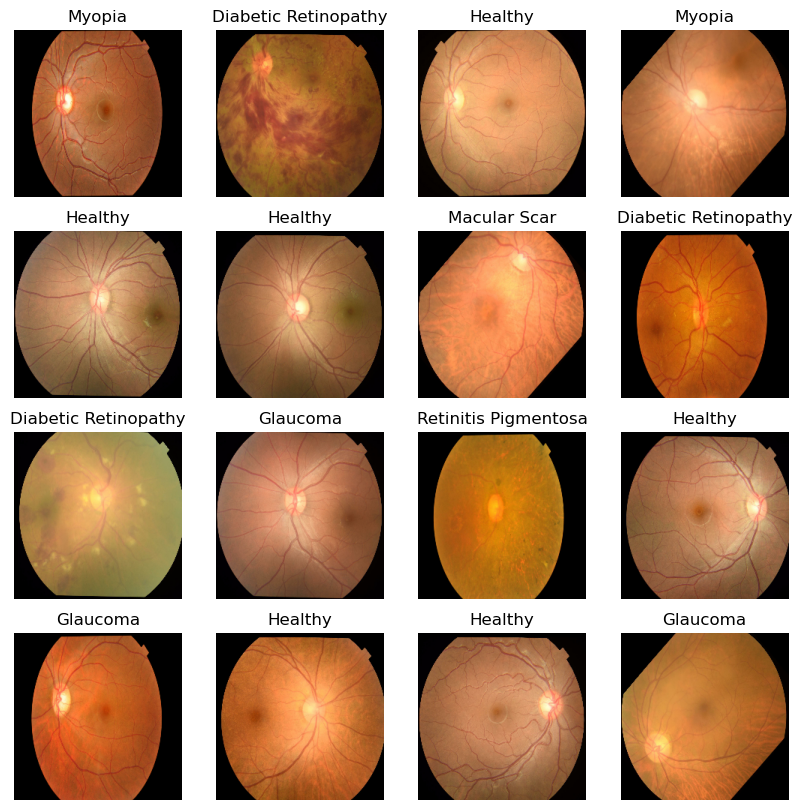

In [8]:
# Visualize the dataset
plt.figure(figsize=(10, 10))
for iamge_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(iamge_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
# Split ratios
train_ratio, val_ratio = 0.7, 0.15

# Calculate sizes
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Shuffle with full buffer size
dataset = dataset.shuffle(buffer_size=dataset_size, seed=123)

In [10]:
# Split the dataset
train_dataset = dataset.take(train_size)
val_test_dataset = dataset.skip(train_size)

val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

In [11]:
# Add performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
# Print dataset sizes
print("Train batches:", train_size)
print("Validation batches:", val_size)
print("Test batches:", test_size)

Train batches: 711
Validation batches: 152
Test batches: 153


In [ ]:
# Load the pre-trained ViT model
base_model = TFViTModel.from_pretrained("google/vit-large-patch16-224")

# Define the Class for the model
classes = 10


# Define the ViT layer
def vit_layer(x):
    return base_model({"pixel_values": x}).last_hidden_state[:, 0, :]


# Define the model
resize_rescale = keras.Sequential([
    keras.layers.Resizing(224, 224),
    keras.layers.Rescaling(1. / 255),
    keras.layers.Permute((3, 1, 2))
])

inputs = keras.layers.Input(shape=(224, 224, 3))
x = resize_rescale(inputs)
x = keras.layers.Lambda(vit_layer)(x)
outputs = keras.layers.Dense(classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [14]:
# Summary (optional)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 3, 224, 224)       0         
_________________________________________________________________
lambda (Lambda)              (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 10,250
Trainable params: 10,250
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Early stopping and learning rate reduction callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [16]:
base_model.trainable = False  # Freeze ViT base model for 1st phase of training

In [17]:
# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# then fit
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
711/711 [==============================] - 215s 251ms/step - loss: 1.0500 - accuracy: 0.6296 - val_loss: 0.8089 - val_accuracy: 0.7056
Epoch 2/100
711/711 [==============================] - 192s 245ms/step - loss: 0.7449 - accuracy: 0.7293 - val_loss: 0.6576 - val_accuracy: 0.7558
Epoch 3/100
711/711 [==============================] - 192s 244ms/step - loss: 0.6794 - accuracy: 0.7493 - val_loss: 0.5913 - val_accuracy: 0.7961
Epoch 4/100
711/711 [==============================] - 191s 243ms/step - loss: 0.6261 - accuracy: 0.7706 - val_loss: 0.5881 - val_accuracy: 0.7907
Epoch 5/100
711/711 [==============================] - 191s 243ms/step - loss: 0.5914 - accuracy: 0.7802 - val_loss: 0.5394 - val_accuracy: 0.7915
Epoch 6/100
711/711 [==============================] - 191s 243ms/step - loss: 0.5731 - accuracy: 0.7833 - val_loss: 0.5405 - val_accuracy: 0.8014
Epoch 7/100
711/711 [==============================] - 191s 243ms/step - loss: 0.5522 - accuracy: 0.7941 - val_loss: 0

In [18]:
# Save the model
model.save("model/eyes_diseases.h5")
model.save("model/eyes_diseases.keras")

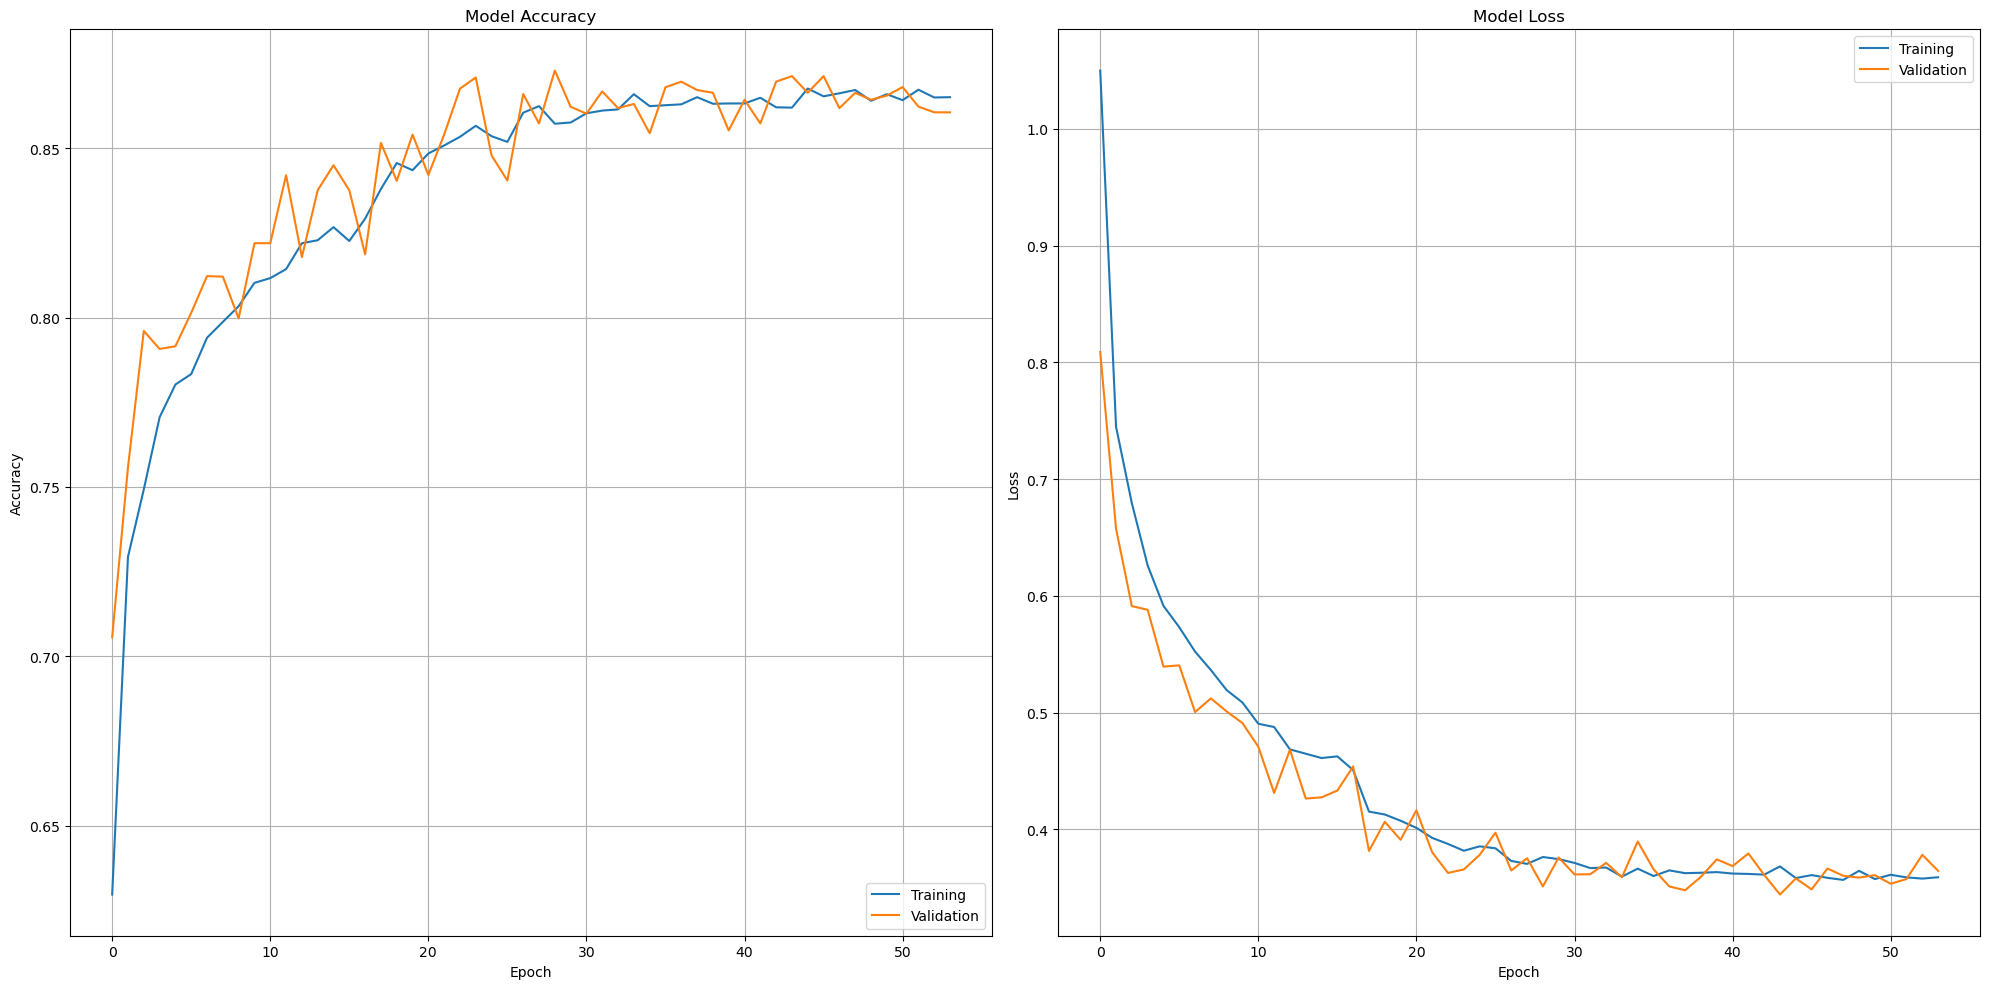

In [19]:
# Create figure and axis objects with a single subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot training & validation loss values
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import classification_report

def evaluate_and_report_model(model, test_dataset, class_names):
    loss, acc = model.evaluate(test_dataset)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {acc:.4f}")

    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

evaluate_and_report_model(model, test_dataset, class_names)

153/153 [==============================] - 46s 185ms/step - loss: 0.3512 - accuracy: 0.8668
Test Loss: 0.3512
Test Accuracy: 0.8668

=== Classification Report ===
                                  precision    recall  f1-score   support

Central Serous Chorioretinopathy       0.83      0.81      0.82       111
            Diabetic Retinopathy       0.96      0.96      0.96       536
                      Disc Edema       0.96      0.97      0.96       119
                        Glaucoma       0.75      0.78      0.76       389
                         Healthy       0.79      0.81      0.80       391
                    Macular Scar       0.83      0.77      0.80       294
                          Myopia       0.87      0.86      0.87       359
                       Pterygium       1.00      1.00      1.00        18
              Retinal Detachment       1.00      0.98      0.99        97
            Retinitis Pigmentosa       0.96      0.97      0.97       134

                     

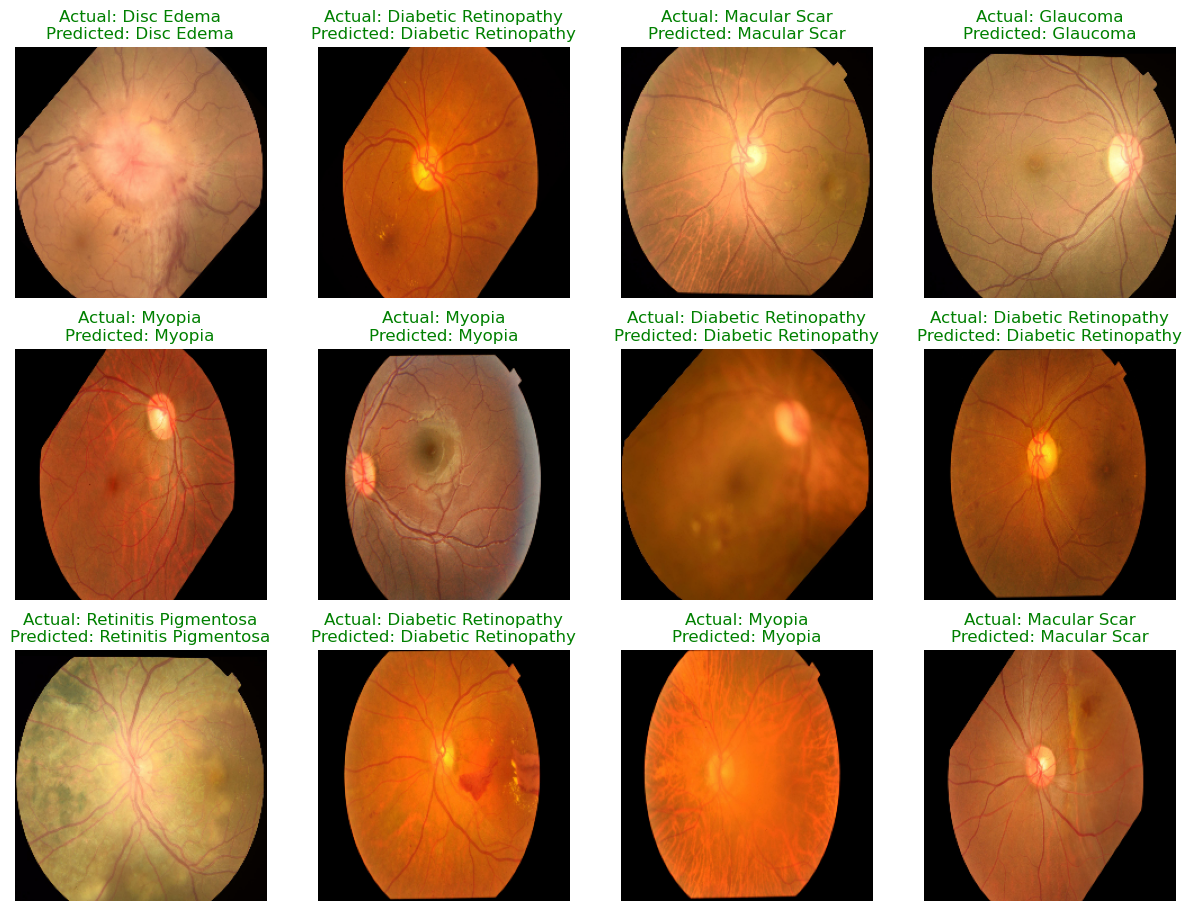

In [29]:
# Predictions using the model
for image_batch, labels_batch in test_dataset.take(1):  # Take one batch from test dataset
    ps = model.predict(image_batch)  # Get model predictions for the batch
    images = image_batch.numpy().astype("uint8")  # Convert images to numpy array
    labels = labels_batch.numpy()  # Convert labels to numpy array

    plt.figure(figsize=(15, 15))  # Create a figure with specified size
    for i in range(12):  # Loop through first 12 images
        ax = plt.subplot(4, 4, i + 1)  # Create a 4x4 subplot grid
        plt.imshow(images[i])  # Display the image
        
        # Get prediction confidence
        confidence = ps[i][ps[i].argmax()] * 100
        
        # Check if prediction is correct
        is_correct = labels[i] == ps[i].argmax()
        color = "green" if is_correct else "red"
        
        # Create title with actual label, predicted label, and confidence
        title = f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[ps[i].argmax()]}"
        plt.title(title, color=color)  # Show title with color
        plt.axis("off")  # Hide axes